In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil, sqrt

In [2]:
df_final = pd.read_csv('data\COVID-19-final.csv', ';')
df_final.head()

,code,country,gdp,hdi,uhc,pop_0_14,pop_15_64,pop_65+,week,prev_cases,prev_deaths,cases,deaths
0,AFG,Afghanistan,2.225761e+08,0.496,0.37,0.430902,0.543249,0.025849,1,0.000000,0.0,0.002629,0.000000
1,AFG,Afghanistan,2.225761e+08,0.496,0.37,0.430902,0.543249,0.025849,2,0.002629,0.0,0.010515,0.000000
2,AFG,Afghanistan,2.225761e+08,0.496,0.37,0.430902,0.543249,0.025849,3,0.010515,0.0,0.042059,0.000000
3,AFG,Afghanistan,2.225761e+08,0.496,0.37,0.430902,0.543249,0.025849,4,0.042059,0.0,0.089375,0.000000
4,AFG,Afghanistan,2.225761e+08,0.496,0.37,0.430902,0.543249,0.025849,5,0.089375,0.0,0.299671,0.010515


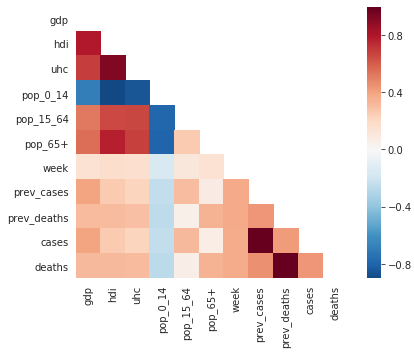

In [3]:
corr = df_final.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, center=0, cmap='RdBu_r', square=True)

# Treinamento

In [4]:
subject_countries = ['BRA','CHN','ESP','DEU','ITA','JPN','KOR','PRT','GBR','USA']

In [5]:
X = df_final[['gdp','hdi','uhc','pop_0_14','pop_15_64','pop_65+','week','prev_cases','prev_deaths']]
X.head()

,gdp,hdi,uhc,pop_0_14,pop_15_64,pop_65+,week,prev_cases,prev_deaths
0,2.225761e+08,0.496,0.37,0.430902,0.543249,0.025849,1,0.000000,0.0
1,2.225761e+08,0.496,0.37,0.430902,0.543249,0.025849,2,0.002629,0.0
2,2.225761e+08,0.496,0.37,0.430902,0.543249,0.025849,3,0.010515,0.0
3,2.225761e+08,0.496,0.37,0.430902,0.543249,0.025849,4,0.042059,0.0
4,2.225761e+08,0.496,0.37,0.430902,0.543249,0.025849,5,0.089375,0.0


In [6]:
y = df_final[['cases','deaths']]
y.head()

,cases,deaths
0,0.002629,0.000000
1,0.010515,0.000000
2,0.042059,0.000000
3,0.089375,0.000000
4,0.299671,0.010515


In [7]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [8]:
random_state = 40
n_splits = 10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
kf = KFold(n_splits)

print('KFold:', n_splits, 'splits\n')
print('Train: X', X_train.shape, '\ty', y_train.shape)
print(' Test: X', X_test.shape, '\ty', y_test.shape)

KFold: 10 splits

Train: X (2560, 9) 	y (2560, 2)
 Test: X (641, 9) 	y (641, 2)


In [9]:
def kfold_train_validate(modelo, kf, X, y):
    historico = []
    
    for k, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        modelo.fit(X.iloc[train_idx], y.iloc[train_idx])
        val_pred = modelo.predict(X.iloc[val_idx])
        val_true = y.iloc[val_idx]
        mae = mean_absolute_error(val_true, val_pred)
        rmse = sqrt(mean_squared_error(val_true, val_pred))
        r2s = r2_score(val_true, val_pred)
        historico.append([k, mae, rmse, r2s])
    
    historico = pd.DataFrame(data=historico, columns=['k', 'MAE', 'RMSE', 'R^2'])
    return historico

def describe_metrics(historico):
    return pd.DataFrame(historico[['MAE', 'RMSE', 'R^2']]).describe().transpose()

def plot_metrics(historico):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21,5))
    sns.lineplot(x='k', y='MAE', data=historico, ax=axs[0])
    sns.lineplot(x='k', y='RMSE', data=historico, ax=axs[1])
    sns.lineplot(x='k', y='R^2', data=historico, ax=axs[2])
    plt.show()

In [10]:
def plot_true_vs_pred(countries):
    if len(countries) > 1:
        cols = 2
        rows = ceil(len(countries) / 2.0)
    else:
        cols = 1
        rows = 1
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(15,7*rows))
    
    axx = 0; axy = 0
    
    if len(countries) % 2 == 1:
        axs[rows-1, 1].remove()
    
    for country in countries:
        df_plot = df_final[df_final['code'] == country].sort_values(by=['week'])
        X_plot = df_plot[['gdp','hdi','uhc','pop_0_14','pop_15_64','pop_65+','week','prev_cases','prev_deaths']]
        df_plot['pred'] = modelo.predict(X_plot)
        
        ax = axs[axx,axy]
        
        ax.set_title(df_plot.iloc[0]['country'])
        sns.scatterplot(x='week', y='cases', data=df_plot, ax=ax, color='b', label='True')
        sns.lineplot(x='week', y='pred', data=df_plot, ax=ax, color='r', label='Pred')
        ax.set_ylabel('cases')
        
        if axy == 1:
            axx = axx + 1
            axy = 0;
        else:
            axy = 1;
        
    plt.subplots_adjust(hspace=0.3)
    plt.show()

In [11]:
y_var = 'cases'
y_train = y_train[y_var]

### RFB com valores default
Segundo a documentação esse são os valores default dos hiper-parâmetros C e epsilon 

In [12]:
kernel = 'rbf'
gamma = 'scale'
C = 1.0
epsilon = 0.1

modelo = SVR(kernel=kernel, gamma=gamma, C=C, epsilon=epsilon)

In [13]:
historico = kfold_train_validate(modelo, kf, X_train, y_train)
describe_metrics(historico)

,count,mean,std,min,25%,50%,75%,max
MAE,10.0,103.076429,16.542904,89.553350,93.026808,100.389449,104.768507,146.287105
RMSE,10.0,265.253447,52.445409,192.833070,226.880047,268.181300,295.641709,368.009175
R^2,10.0,-0.013993,0.021473,-0.053347,-0.019945,-0.012915,-0.007397,0.025644


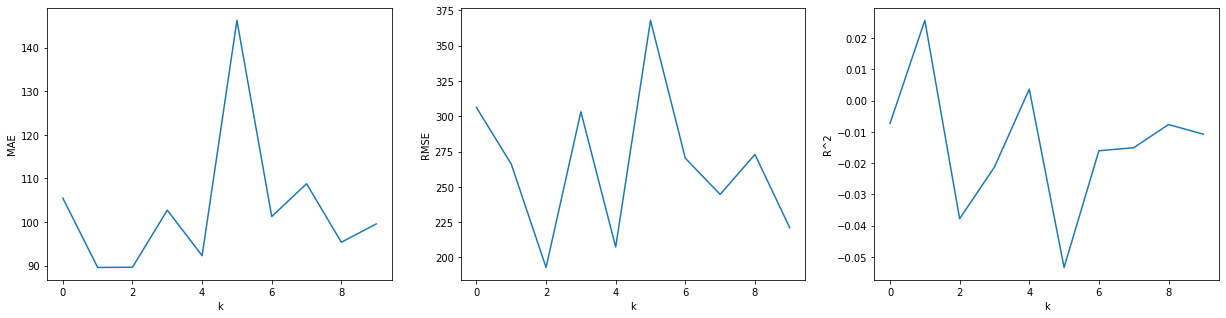

In [14]:
plot_metrics(historico)

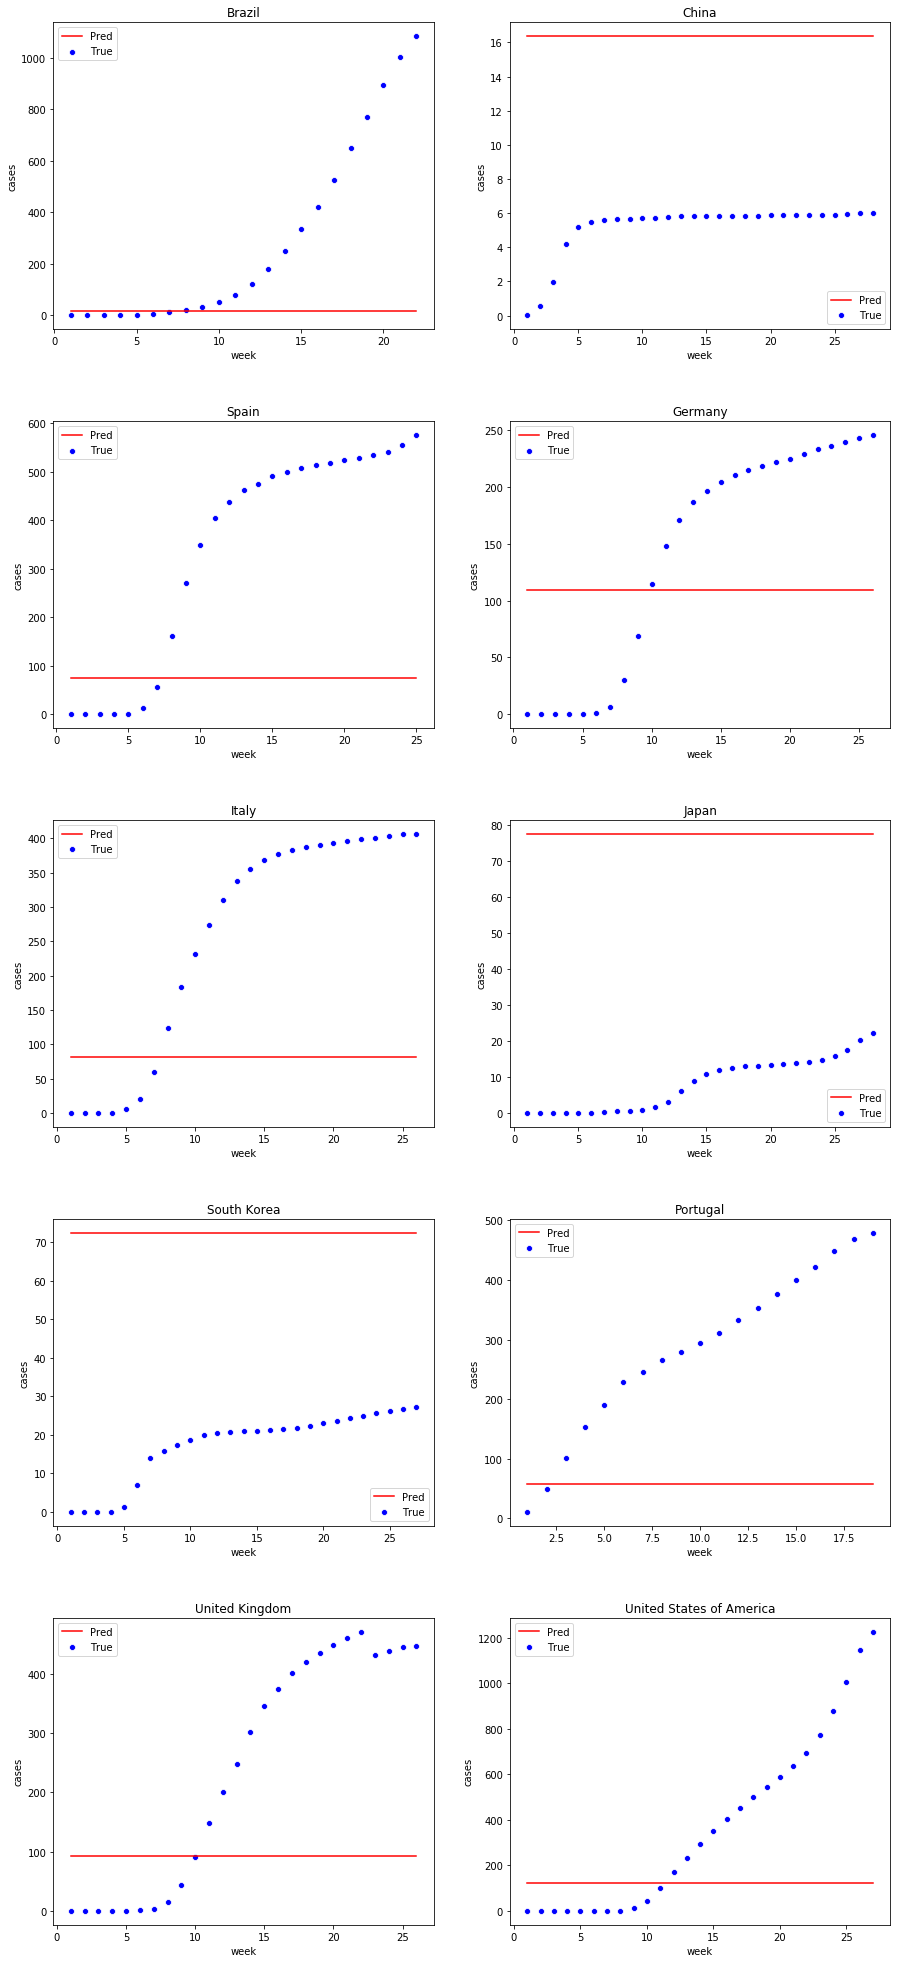

In [15]:
plot_true_vs_pred(subject_countries)

### Pipeline com StandardScaler antes do SVR

In [16]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

In [17]:
modelo = make_pipeline(StandardScaler(), SVR(kernel=kernel, gamma=gamma, C=C, epsilon=epsilon))

In [18]:
historico = kfold_train_validate(modelo, kf, X_train, y_train)
describe_metrics(historico)

,count,mean,std,min,25%,50%,75%,max
MAE,10.0,84.331502,14.854905,70.863635,75.791046,81.690706,84.773067,123.271674
RMSE,10.0,245.508353,55.757941,163.623063,205.230323,251.844123,278.759274,349.322218
R^2,10.0,0.140160,0.063095,0.050911,0.097454,0.122509,0.172474,0.252812


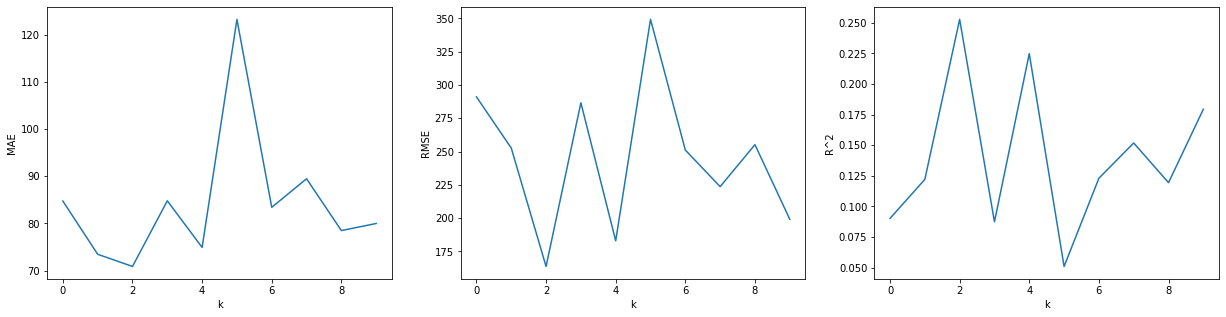

In [19]:
plot_metrics(historico)

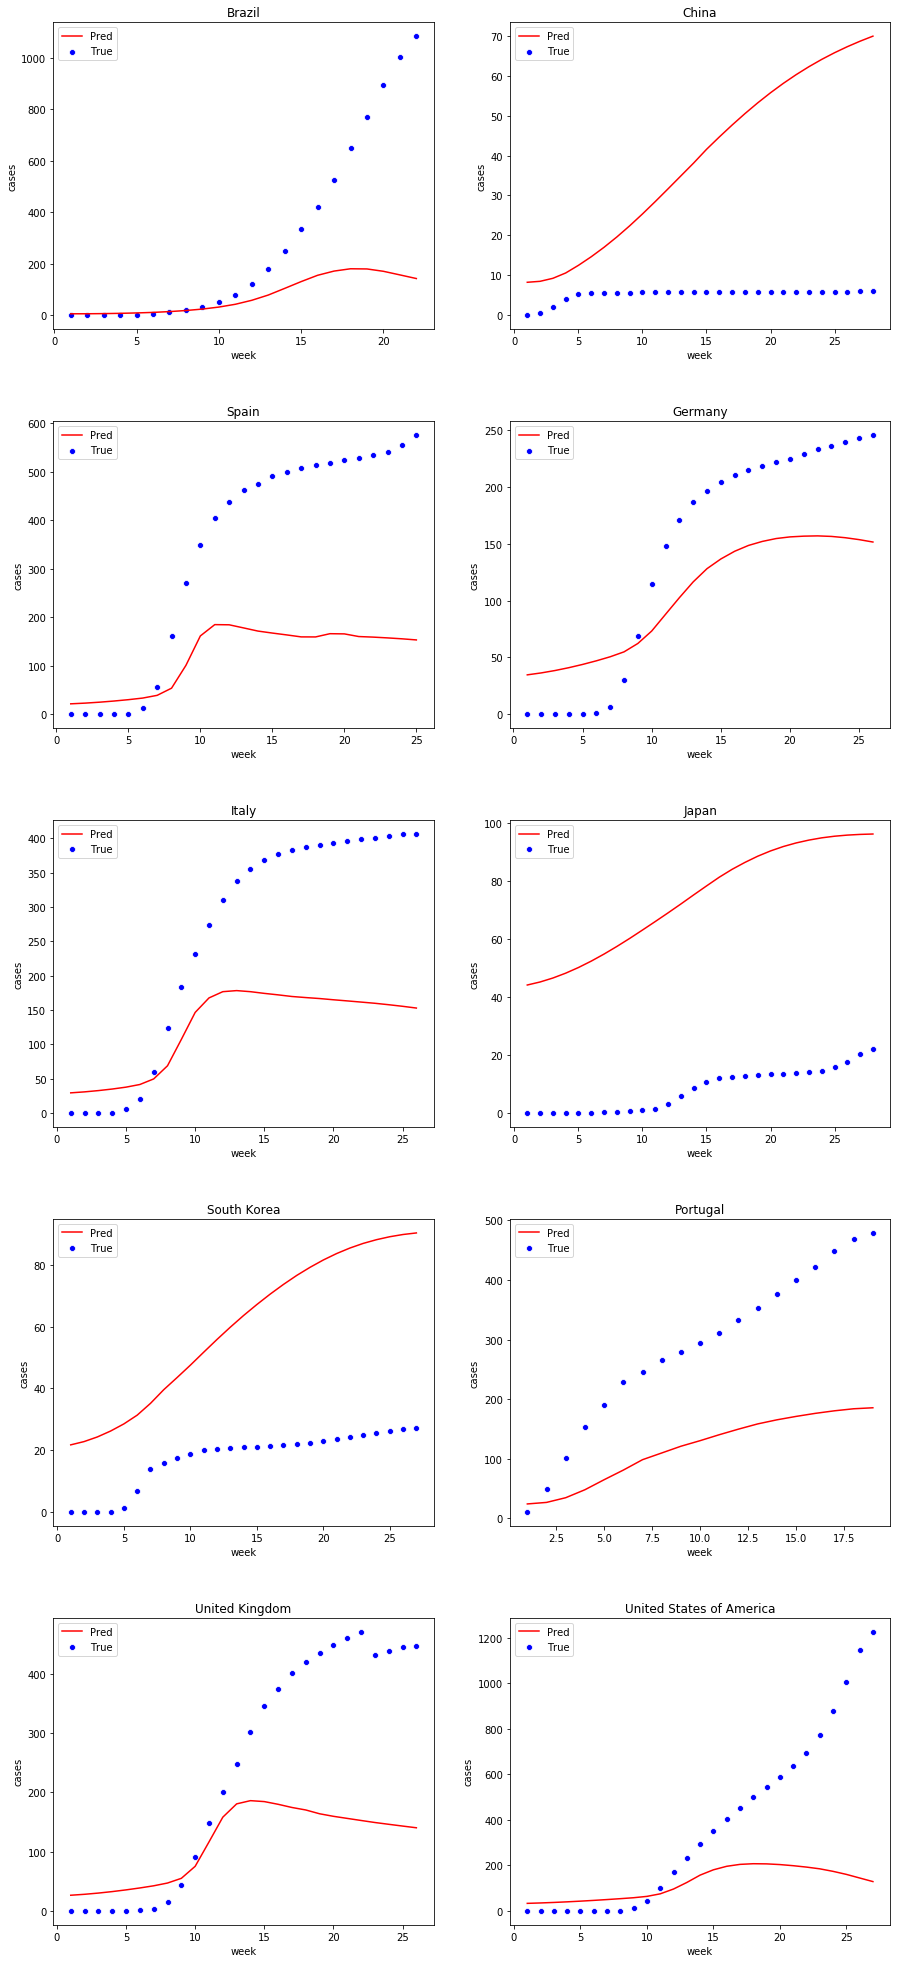

In [20]:
plot_true_vs_pred(subject_countries)

### Busca pelos melhores valores dos hiper-parâmetros C, epsilon e gamma

In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
C_range = np.logspace(0, 3, 4)
epsilon_range = np.logspace(-3, 3, 7)
gamma_range = np.logspace(-3, 3, 7)

print('C_range:', C_range, '\n\nepsilon_range:', epsilon_range, '\n\ngamma_range:', gamma_range)

params = dict(svr__C=C_range, svr__epsilon=epsilon_range, svr__gamma=gamma_range)

C_range: [   1.   10.  100. 1000.] 

epsilon_range: [1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03] 

gamma_range: [1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]


In [23]:
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('svr', SVR())])

grid = GridSearchCV(pipe, param_grid=params, cv=kf, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svr',
                                        SVR(C=1.0, cache_size=200, coef0=0.0,
                                            degree=3, epsilon=0.1,
                                            gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            shrinking=True, tol=0.001,
                                            verbose=False))],
                                verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'svr__

In [24]:
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'svr__C': 1000.0, 'svr__epsilon': 1.0, 'svr__gamma': 0.01} with a score of 0.99


### Execução com os melhores hiper-parâmetros encontrados

In [25]:
C = 1000.0
epsilon = 1.0
gamma = 0.01

modelo = make_pipeline(StandardScaler(), SVR(kernel=kernel, gamma=gamma, C=C, epsilon=epsilon))

In [26]:
historico = kfold_train_validate(modelo, kf, X_train, y_train)
describe_metrics(historico)

,count,mean,std,min,25%,50%,75%,max
MAE,10.0,8.810063,1.280538,6.632697,7.887588,9.265686,9.394423,11.051323
RMSE,10.0,21.962730,5.293460,13.979958,18.682756,21.486731,23.647855,32.320100
R^2,10.0,0.992243,0.003794,0.986988,0.988803,0.992531,0.995590,0.997356


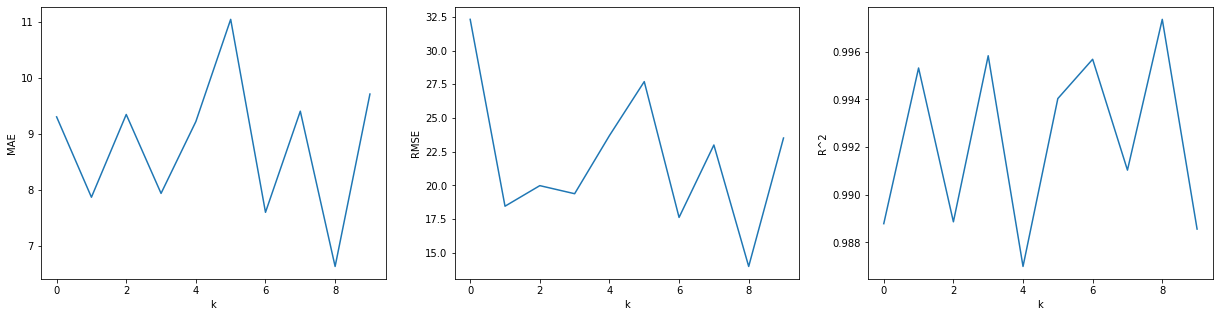

In [27]:
plot_metrics(historico)

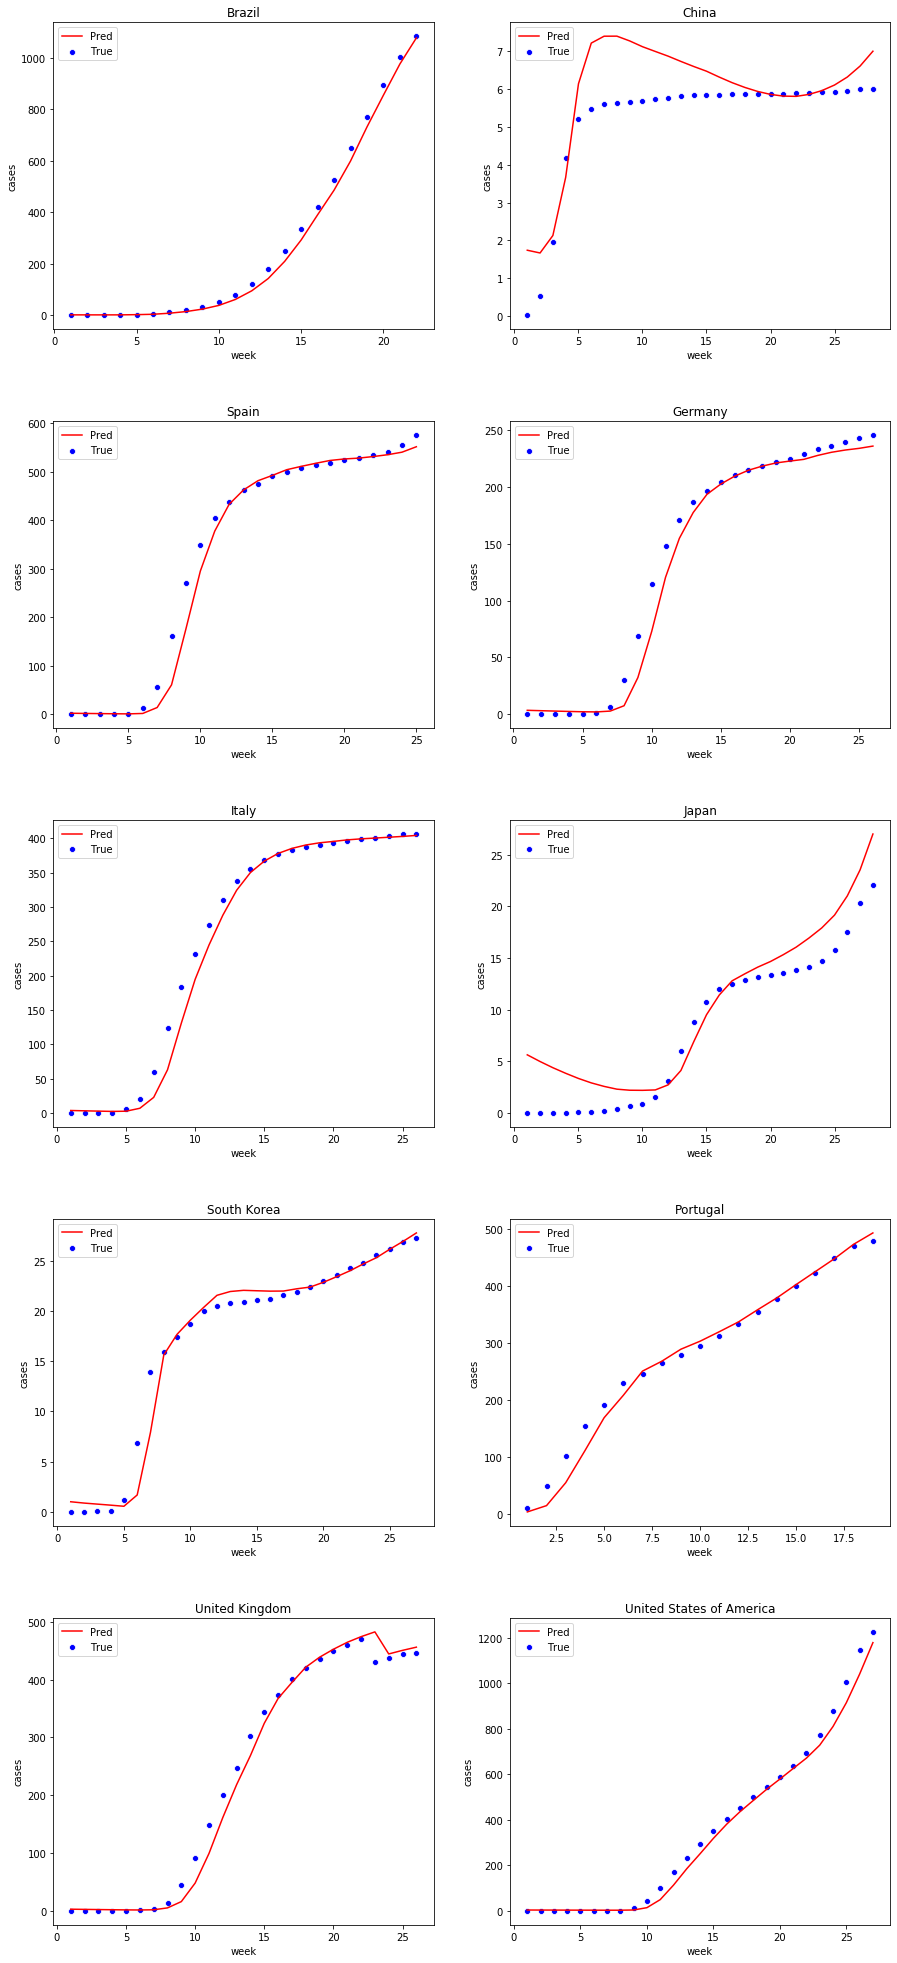

In [28]:
plot_true_vs_pred(subject_countries)

# Teste

In [29]:
test_pred = modelo.predict(X_test)
test_true = y_test['cases']
test_mae = mean_absolute_error(test_true, test_pred)
test_rmse = sqrt(mean_squared_error(test_true, test_pred))
test_r2s = r2_score(test_true, test_pred)

df_test = pd.DataFrame(data=[[test_mae, test_rmse, test_r2s]], columns=['MAE', 'RMSE', 'R^2'])

df_test

,MAE,RMSE,R^2
0,8.81311,20.654361,0.993529
